In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
import sfp 
import torch
from torch.utils import data as torchdata
import glob
import os
import warnings
import itertools
#import altair as alt
import arviz as az
import pymc3 as pm
import theano.tensor as tt
import theano

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
sns.set_style('whitegrid')
#df_path = "/users/broderick/mnt/Acadia/Projects/spatial_frequency_preferences/BIDS/derivatives/simulated_data/noise-stim_class_posterior_sub-wlsubj045_ses-02_task-sfp_v1_e1-12/n100_iso_full_constant_s1_a.75_b.25_rmc0_rmo0_rac0_rao0_amc0_amo0_aac0_aao0_l1_simulated.csv"
df_path_sim = "/mnt/winawerlab/Projects/spatial_frequency_preferences/BIDS/derivatives/simulated_data/noise-stim_class_posterior_sub-wlsubj045_ses-02_task-sfp_v1_e1-12/n5500_iso_full_constant_s1_a.75_b.25_rmc0_rmo0_rac0_rao0_amc0_amo0_aac0_aao0_l1_simulated.csv"
df_path = '/mnt/winawerlab/Projects/spatial_frequency_preferences/BIDS/derivatives/first_level_analysis/stim_class/posterior/sub-wlsubj045/ses-04/sub-wlsubj045_ses-04_task-sfprescaled_v1_e1-12_summary.csv'

Failed to import duecredit due to No module named 'duecredit'
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [691]:
df_sim = pd.read_csv(df_path_sim)

In [ ]:
# df = pd.read_csv(df_path)

I think minibatch just won't work, which is fine.

normalize targets when initializing tensors, below (or just grab the normalized ones?). and then calculate the precision based on that.

In [693]:
df_sim['normed_precision'] = 1. / (df_sim.amplitude_estimate_std_error ** 2)

In [696]:
def get_tensors_from_df(df, minibatch_size=500):
    tensors = {}
    map_tensor_batch = {}
    for tensor_name, df_name in zip(['sf_mag', 'sf_angle', 'vox_ecc', 'vox_angle', 'targets', 'precision', ], 
                                    ['local_sf_magnitude', 'local_sf_xy_direction', 'eccen', 'angle', 'amplitude_estimate_median_normed', 'normed_precision']):
        arr = df.groupby(['voxel', 'stimulus_class'])[[df_name]].mean().unstack().to_numpy()
        tensors[tensor_name] = theano.shared(arr)
        map_tensor_batch[tensors[tensor_name]] = pm.Minibatch(arr, minibatch_size)
    return tensors, map_tensor_batch

In [697]:
#filtered_df = sfp.model.drop_voxels_with_negative_amplitudes(df)
#filtered_df = sfp.model.drop_voxels_near_border(filtered_df)
#tensors, map_tensor_batch = get_tensors_from_df(filtered_df)
tensors, map_tensor_batch = get_tensors_from_df(df_sim)

In [698]:
def pymc_log_gauss_donut(sf_mag, sf_angle, vox_ecc, vox_angle, targets, precision, n_voxels, n_classes,
                         orientation_type='iso', eccentricity_type='full', vary_amplitude=False):
    random_param, param_val = {}, {}
    for ori, param, angle in itertools.product(['abs', 'rel'], ['mode', 'amplitude'],
                                               ['cardinals', 'obliques']):
        random_param['%s_%s_%s' % (ori, param, angle)] = True
        param_val['%s_%s_%s' % (ori, param, angle)] = 0
    for var in ['slope', 'intercept']:
        random_param['sf_ecc_%s' % var] = True
        param_val['sf_ecc_%s' % var] = .5
    param_val, random_param = sfp.model._check_log_gaussian_params(param_val, random_param, orientation_type, 
                                                                   eccentricity_type, vary_amplitude)
    params = {}
    model = pm.Model()
    with model:
        normed_targets = targets / targets.norm(2, 1, keepdims=True)
        voxel_norm = pm.Normal('voxel_norm', mu=1, sd=.25, shape=(n_voxels, 1), )
        params['sigma'] = pm.Bound(pm.Normal, lower=0)('sigma', mu=1, sd=.25)
        for k, v in param_val.items():
            if random_param[k]:
                params[k] = pm.Normal(k, mu=v, sd=.25)
            else:
                params[k] = pm.Deterministic(k, tt.as_tensor(v))
        rel_sf_angle = sf_angle - vox_angle
        eccentricity_effect = params['sf_ecc_slope'] * vox_ecc + params['sf_ecc_intercept']
        orientation_effect = (1 + params['abs_mode_cardinals'] * tt.cos(2 * sf_angle) +
                              params['abs_mode_obliques'] * tt.cos(4 * sf_angle) +
                              params['rel_mode_cardinals'] * tt.cos(2 * rel_sf_angle) +
                              params['rel_mode_obliques'] * tt.cos(4 * rel_sf_angle))
        preferred_period = pm.math.clip(eccentricity_effect * orientation_effect, 1e-6, 1e6)

        max_amplitude = pm.math.clip(1 + params['abs_amplitude_cardinals'] * tt.cos(2*sf_angle) +
                                     params['abs_amplitude_obliques'] * tt.cos(4*sf_angle) +
                                     params['rel_amplitude_cardinals'] * tt.cos(2*rel_sf_angle) +
                                     params['rel_amplitude_obliques'] * tt.cos(4*rel_sf_angle), 1e-6, 1e6)
        pdf = tt.exp(-((tt.log2(sf_mag) + tt.log2(preferred_period))**2) / (2*params['sigma']**2))
        predicted_response = voxel_norm * max_amplitude * pdf
        noisy_response = pm.Normal('noisy_response', mu=predicted_response, sd=1./precision, observed=normed_targets,)
    return model

In [699]:
iso_model = pymc_log_gauss_donut(**tensors, n_voxels=df_sim.voxel.nunique(), n_classes=df_sim.stimulus_class.nunique())

In [688]:
import time
tracker = pm.callbacks.Tracker(
    mean=advi.approx.mean.eval,  # callable that returns mean
    std=advi.approx.std.eval,  # callable that returns std
    time=time.time
)

In [702]:
with iso_model:
    advi=pm.ADVI()
    advi_fit = advi.fit(10000, obj_optimizer=pm.adam(learning_rate=.01), )#more_replacements=map_tensor_batch,)# callbacks=[tracker])

Average Loss = 7.3834e+07: 100%|█████████▉| 9999/10000 [03:47<00:00, 41.66it/s]Interrupted at 9,999 [99%]: Average Loss = 5.2488e+08


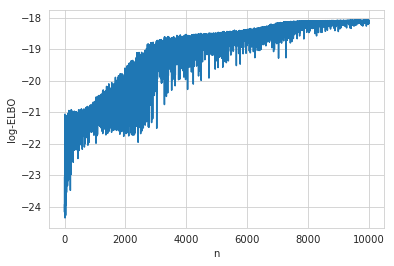

In [703]:
advi_elbo = pd.DataFrame(
    {'log-ELBO': -np.log(advi_fit.hist),
     'n': np.arange(advi_fit.hist.shape[0])})

_ = sns.lineplot(y='log-ELBO', x='n', data=advi_elbo)

In [704]:
advi_trace = advi_fit.sample()

In [705]:
pm.summary(advi_trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
voxel_norm__0_0,0.271443,0.005547,0.000240,0.260882,0.281987
voxel_norm__1_0,0.275374,0.005818,0.000250,0.265055,0.287886
voxel_norm__2_0,0.267631,0.006025,0.000229,0.255851,0.278784
voxel_norm__3_0,0.285227,0.006285,0.000321,0.274080,0.298588
voxel_norm__4_0,0.269664,0.005168,0.000256,0.259169,0.278615
voxel_norm__5_0,0.275211,0.005934,0.000254,0.263404,0.286178
voxel_norm__6_0,0.277030,0.005036,0.000222,0.267472,0.286863
voxel_norm__7_0,0.264616,0.005451,0.000245,0.253591,0.275372
voxel_norm__8_0,0.273191,0.005997,0.000285,0.259833,0.283661
voxel_norm__9_0,0.249569,0.006327,0.000324,0.238035,0.261156


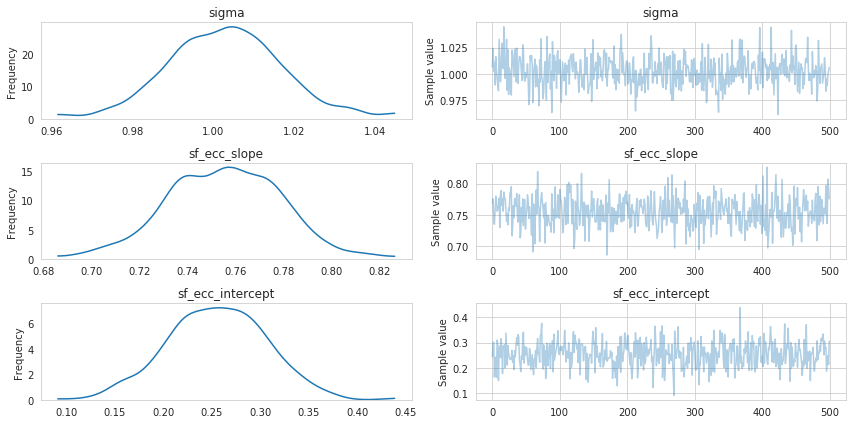

In [706]:
pm.traceplot(advi_trace, ['sigma', 'sf_ecc_slope', 'sf_ecc_intercept']);

In [707]:
#Can't use the pm.init_nuts (or similarly through pm.sample) because it doesn't let us override the callbacks, so here we implement our own version
import logging
_log = logging.getLogger('pymc3')
def convert_advi_to_nuts_init(approx, method='advi', chains=1, model=None, **kwargs):
    """Set up the mass matrix initialization for NUTS starting from a fit ADVI approximation.

    NUTS convergence and sampling speed is extremely dependent on the
    choice of mass/scaling matrix. This function implements different
    methods for choosing or adapting the mass matrix.

    Parameters
    ----------
    approx : output of pm.fit
        ADVI approximation of the posterior to adapt to NUTS initialization.
    method : str
        Initialization method to use.

        * advi+adapt_diag : adapt the resulting diagonal mass matrix based on the
          sample variance of the tuning samples.
        * advi+adapt_diag_grad : adapt the resulting diagonal mass matrix based
          on the variance of the gradients during tuning. This is **experimental** and might be
          removed in a future release.
        * advi : Use ADVI's approximation to estimate posterior mean and diagonal mass matrix.
    chains : int
        Number of jobs to start.
    model : Model (optional if in `with` context)
    **kwargs : keyword arguments
        Extra keyword arguments are forwarded to pymc3.NUTS.

    Returns
    -------
    start : pymc3.model.Point
        Starting point for sampler
    nuts_sampler : pymc3.step_methods.NUTS
        Instantiated and initialized NUTS sampler object
    """
    model = pm.model.modelcontext(model)

    vars = kwargs.get('vars', model.vars)
    if set(vars) != set(model.vars):
        raise ValueError('Must use init_nuts on all variables of a model.')
    if not pm.model.all_continuous(vars):
        raise ValueError('init_nuts can only be used for models with only '
                         'continuous variables.')

    if not isinstance(method, str):
        raise TypeError('method must be a string.')

    if method is not None:
        method = method.lower()

    _log.info('Initializing NUTS using {}...'.format(method))

    if method == 'advi+adapt_diag_grad':
        start = approx.sample(draws=chains)
        start = list(start)
        stds = approx.bij.rmap(approx.std.eval())
        cov = model.dict_to_array(stds) ** 2
        mean = approx.bij.rmap(approx.mean.get_value())
        mean = model.dict_to_array(mean)
        weight = 50
        potential = pm.step_methods.hmc.quadpotential.QuadPotentialDiagAdaptGrad(
            model.ndim, mean, cov, weight)
    elif method == 'advi+adapt_diag':
        start = approx.sample(draws=chains)
        start = list(start)
        stds = approx.bij.rmap(approx.std.eval())
        cov = model.dict_to_array(stds) ** 2
        mean = approx.bij.rmap(approx.mean.get_value())
        mean = model.dict_to_array(mean)
        weight = 50
        potential = pm.step_methods.hmc.quadpotential.QuadPotentialDiagAdapt(
            model.ndim, mean, cov, weight)
    elif method == 'advi':
        start = approx.sample(draws=chains)
        start = list(start)
        stds = approx.bij.rmap(approx.std.eval())
        cov = model.dict_to_array(stds) ** 2
        potential = pm.step_methods.hmc.quadpotential.QuadPotentialDiag(cov)

    step = pm.NUTS(potential=potential, model=model, **kwargs)

    return start, step

In [709]:
nchains = 4
with iso_model:
    start, step = convert_advi_to_nuts_init(advi_fit, 'advi+adapt_diag', chains=nchains)
    iso_trace = pm.sample(500, step=step, start=start, chains=nchains, cores=2, )#nuts_kwargs={'target_accept': .99})
    #iso_trace = pm.sample(500, chains=nchains, cores=2, nuts_kwargs={'target_accept': .99})
#prior = pm.sample_prior_predictive(model=iso_model)
#post = pm.sample_posterior_predictive(iso_trace, 500, iso_model)

Initializing NUTS using advi+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sf_ecc_intercept, sf_ecc_slope, sigma, voxel_norm]
Sampling 4 chains:   7%|▋         | 290/4000 [14:38<3:40:52,  3.57s/draws]

ValueError: Not enough samples to build a trace.

In [34]:
data = az.from_pymc3(iso_trace,)# prior=prior, posterior_predictive=post)

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


In [122]:
pm.summary(iso_trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
sigma,0.995410,0.000508,0.000029,0.994443,0.996432
sf_ecc_slope,0.758305,0.000444,0.000026,0.757433,0.759219
sf_ecc_intercept,0.196928,0.001248,0.000068,0.194150,0.199080
voxel_normalization_factor,0.277978,0.000067,0.000003,0.277854,0.278119
abs_mode_cardinals,0.000000,0.000000,0.000000,0.000000,0.000000
abs_mode_obliques,0.000000,0.000000,0.000000,0.000000,0.000000
abs_amplitude_cardinals,0.000000,0.000000,0.000000,0.000000,0.000000
abs_amplitude_obliques,0.000000,0.000000,0.000000,0.000000,0.000000
rel_mode_cardinals,0.000000,0.000000,0.000000,0.000000,0.000000
rel_mode_obliques,0.000000,0.000000,0.000000,0.000000,0.000000


In [35]:
data.posterior.sigma.mean('draw')

<xarray.DataArray 'sigma' (chain: 1)>
array([0.976655])
Coordinates:
  * chain    (chain) int64 0

In [29]:
data.posterior.sf_ecc_slope.mean('draw')

<xarray.DataArray 'sf_ecc_slope' (chain: 10)>
array([-0.028784,  1.022146,  0.922808,  1.382798,  1.233152,  0.737365,
        1.625437, -6.064605,  0.873978,  0.938674])
Coordinates:
  * chain    (chain) int64 0 1 2 3 4 5 6 7 8 9

In [30]:
data.posterior.sf_ecc_intercept.mean('draw')

<xarray.DataArray 'sf_ecc_intercept' (chain: 10)>
array([ 3.154334e-01,  6.218093e-01,  1.903786e-01,  3.705491e-01,
       -1.292371e-01,  2.238005e-01,  2.636419e+00, -5.738690e+00,
        2.150982e-01, -2.715902e-03])
Coordinates:
  * chain    (chain) int64 0 1 2 3 4 5 6 7 8 9

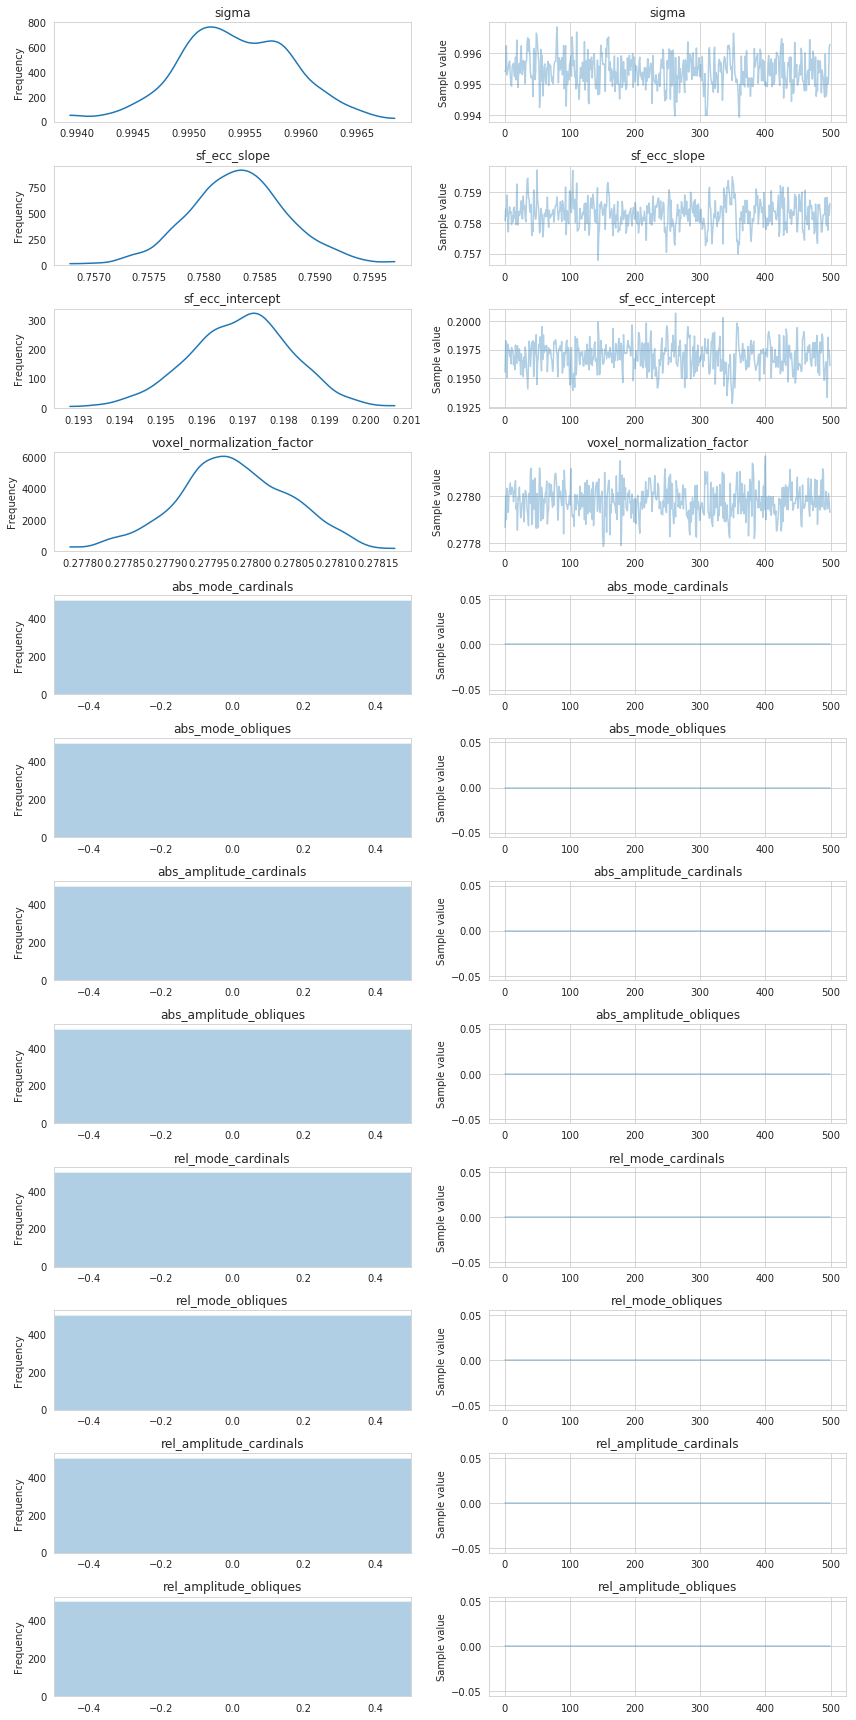

In [69]:
pm.traceplot(iso_trace);

# Pyro
Need to rescale predictions and targets

In [36]:
dataset = sfp.model.FirstLevelDataset('tmp.csv', device,)# sfp.model.construct_df_filter('drop_voxels_with_negative_amplitudes,drop_voxels_near_border'))
dataloader = torchdata.DataLoader(dataset, len(dataset))

In [43]:
import pyro
from pyro.infer import mcmc
model = sfp.model.LogGaussianDonut('full', 'full')

def call_model(features, precision):
    priors = {}
    for k, v in model.named_parameters():
        if not v.requires_grad:
            # we only want to deal with the parameters that require training
            continue
        if k == 'sigma':
            priors[k] = pyro.distributions.Normal(features.new_tensor(1), features.new_tensor(.25))
        elif k.startswith('sf'):
            priors[k] = pyro.distributions.Normal(features.new_tensor(.5), features.new_tensor(.25))
        else:
            #priors[k] = pyro.distributions.Gamma(1, 5)
            priors[k] = pyro.distributions.Normal(features.new_tensor(.5), features.new_tensor(.25))
    lifted_module = pyro.random_module('module', model, priors)
    lifted_model = lifted_module()
    predictions = lifted_model(features)
    rescaled_predictions = predictions / predictions.norm(2, -1, True)
    return pyro.sample('noisy_predictions', pyro.distributions.Normal(rescaled_predictions, 1./precision))

def call_conditioned_model(features, target, precision):
    rescaled_target = target / target.norm(2, -1, True)
    return pyro.condition(call_model, data={'noisy_predictions': rescaled_target})(features, precision)

In [41]:
features, targets = next(iter(dataloader))
precision = targets.select(-1, 1)
targets = targets.select(-1, 0)

In [55]:
pyro.clear_param_store()
nuts_kernel = mcmc.NUTS(call_conditioned_model, adapt_step_size=True)
hmc = mcmc.MCMC(nuts_kernel, num_samples=500, num_chains=1)

In [ ]:
# ISSUES WITH NUM_CHAINS > 1 probably due to issues with pytorch multiprocessing

In [56]:
hmc_posterior = hmc.run(features, targets, precision)

Sample: 100%|██████████| 1000/1000 [01:06<00:00, 15.04it/s, step size=7.40e-02, acc. rate=0.955]


In [12]:
pyro_data_iso = az.from_pyro(hmc_posterior)

In [17]:
pyro_data_iso.posterior

<xarray.Dataset>
Dimensions:                    (chain: 1, draw: 100)
Coordinates:
  * chain                      (chain) int64 0
  * draw                       (draw) int64 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
Data variables:
    module$$$sigma             (chain, draw) float64 0.9697 0.9786 ... 0.9788
    module$$$sf_ecc_slope      (chain, draw) float64 0.74 0.733 ... 0.7448
    module$$$sf_ecc_intercept  (chain, draw) float64 0.1867 0.2494 ... 0.1943
Attributes:
    created_at:                 2019-04-02T21:30:08.832168
    inference_library:          pyro
    inference_library_version:  0.3.1

In [18]:
pyro_data_full.posterior

<xarray.Dataset>
Dimensions:                           (chain: 1, draw: 100)
Coordinates:
  * chain                             (chain) int64 0
  * draw                              (draw) int64 0 1 2 3 4 ... 95 96 97 98 99
Data variables:
    module$$$sigma                    (chain, draw) float64 0.9748 ... 0.9711
    module$$$abs_amplitude_cardinals  (chain, draw) float64 0.003297 ... -0.002975
    module$$$abs_amplitude_obliques   (chain, draw) float64 -0.004145 ... 0.001009
    module$$$rel_amplitude_cardinals  (chain, draw) float64 -0.002018 ... -0.00707
    module$$$rel_amplitude_obliques   (chain, draw) float64 0.003386 ... -0.0009014
    module$$$abs_mode_cardinals       (chain, draw) float64 -0.001487 ... -0.005134
    module$$$abs_mode_obliques        (chain, draw) float64 -0.002583 ... -0.002509
    module$$$rel_mode_cardinals       (chain, draw) float64 -0.00794 ... -0.001675
    module$$$rel_mode_obliques        (chain, draw) float64 -0.0003585 ... 0.000501
    module$$$s

In [57]:
params = ['module$$$'+i[0] for i in model.named_parameters()]
marginals = hmc_posterior.marginal(params)
marginals.support().keys()

odict_keys(['module$$$sigma', 'module$$$abs_amplitude_cardinals', 'module$$$abs_amplitude_obliques', 'module$$$rel_amplitude_cardinals', 'module$$$rel_amplitude_obliques', 'module$$$abs_mode_cardinals', 'module$$$abs_mode_obliques', 'module$$$rel_mode_cardinals', 'module$$$rel_mode_obliques', 'module$$$sf_ecc_slope', 'module$$$sf_ecc_intercept'])

In [58]:
samples = {}
for k, v in marginals.support().items():
    samples[k.replace('module$$$', '')] = v
samples = pd.DataFrame(samples)
samples['sample_num'] = range(len(samples))
samples = pd.melt(samples, 'sample_num', var_name='model_parameter')

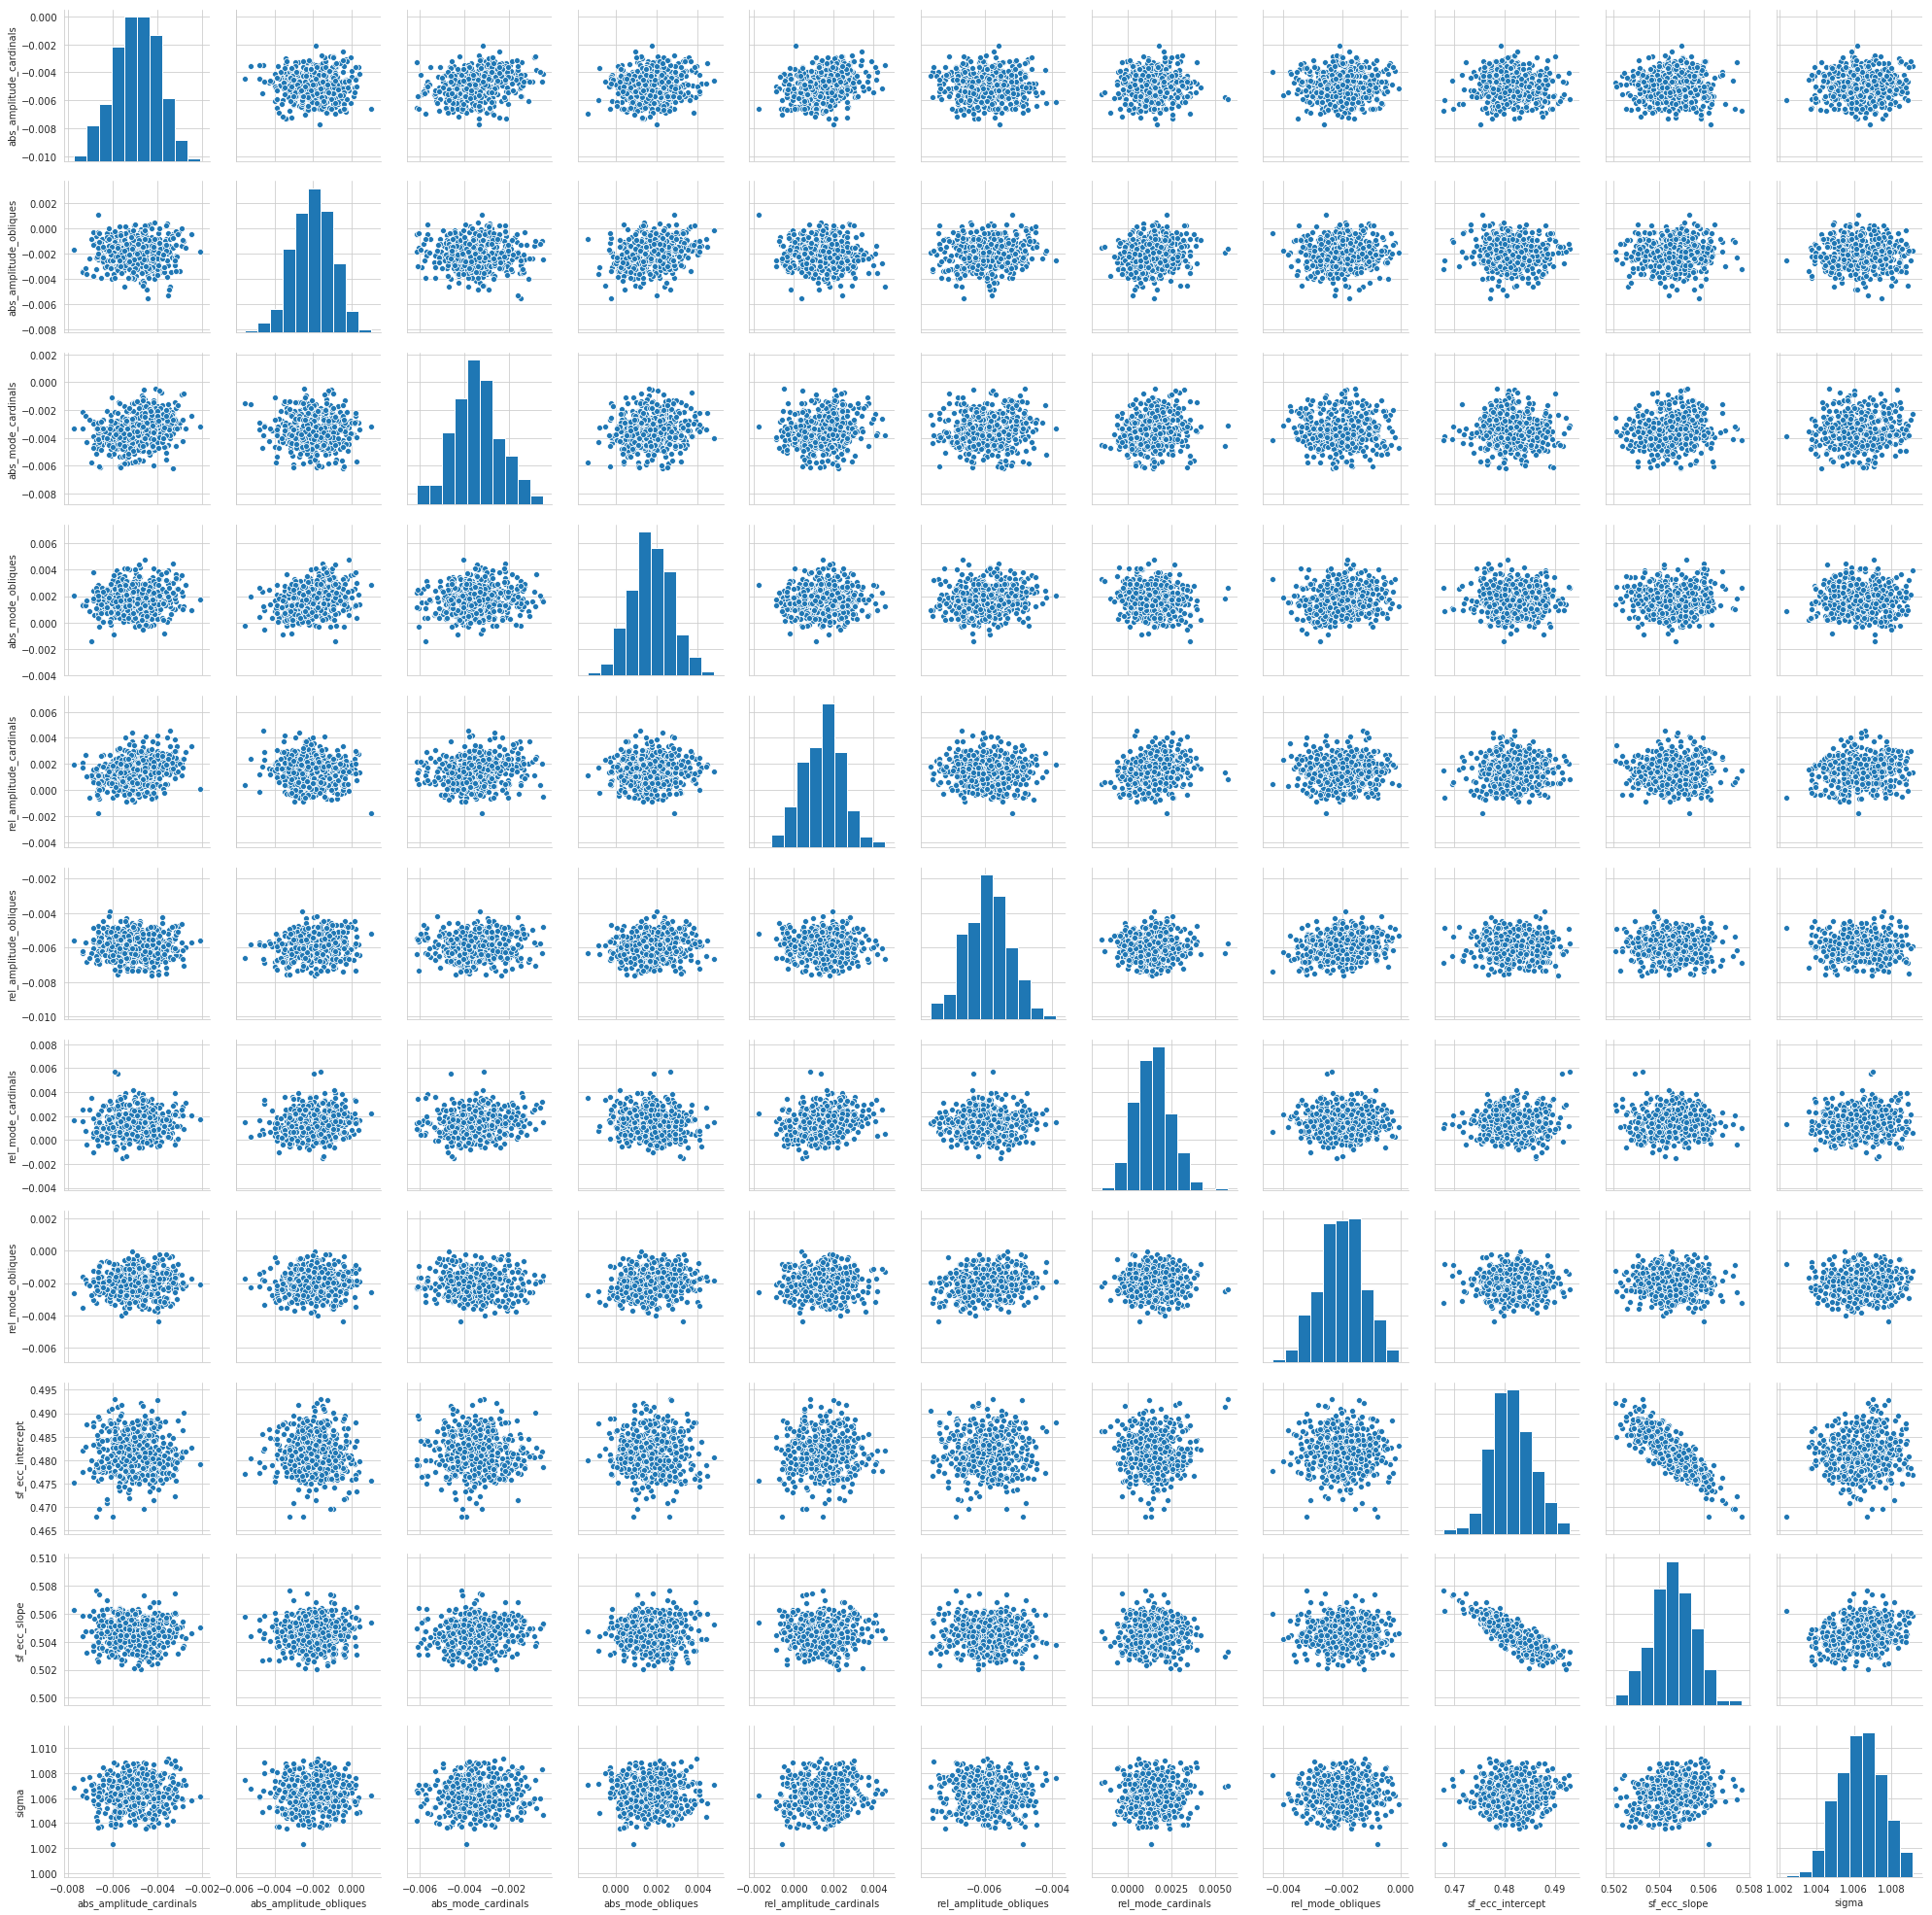

In [59]:
sns.pairplot(samples.pivot('sample_num', 'model_parameter', 'value'))

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


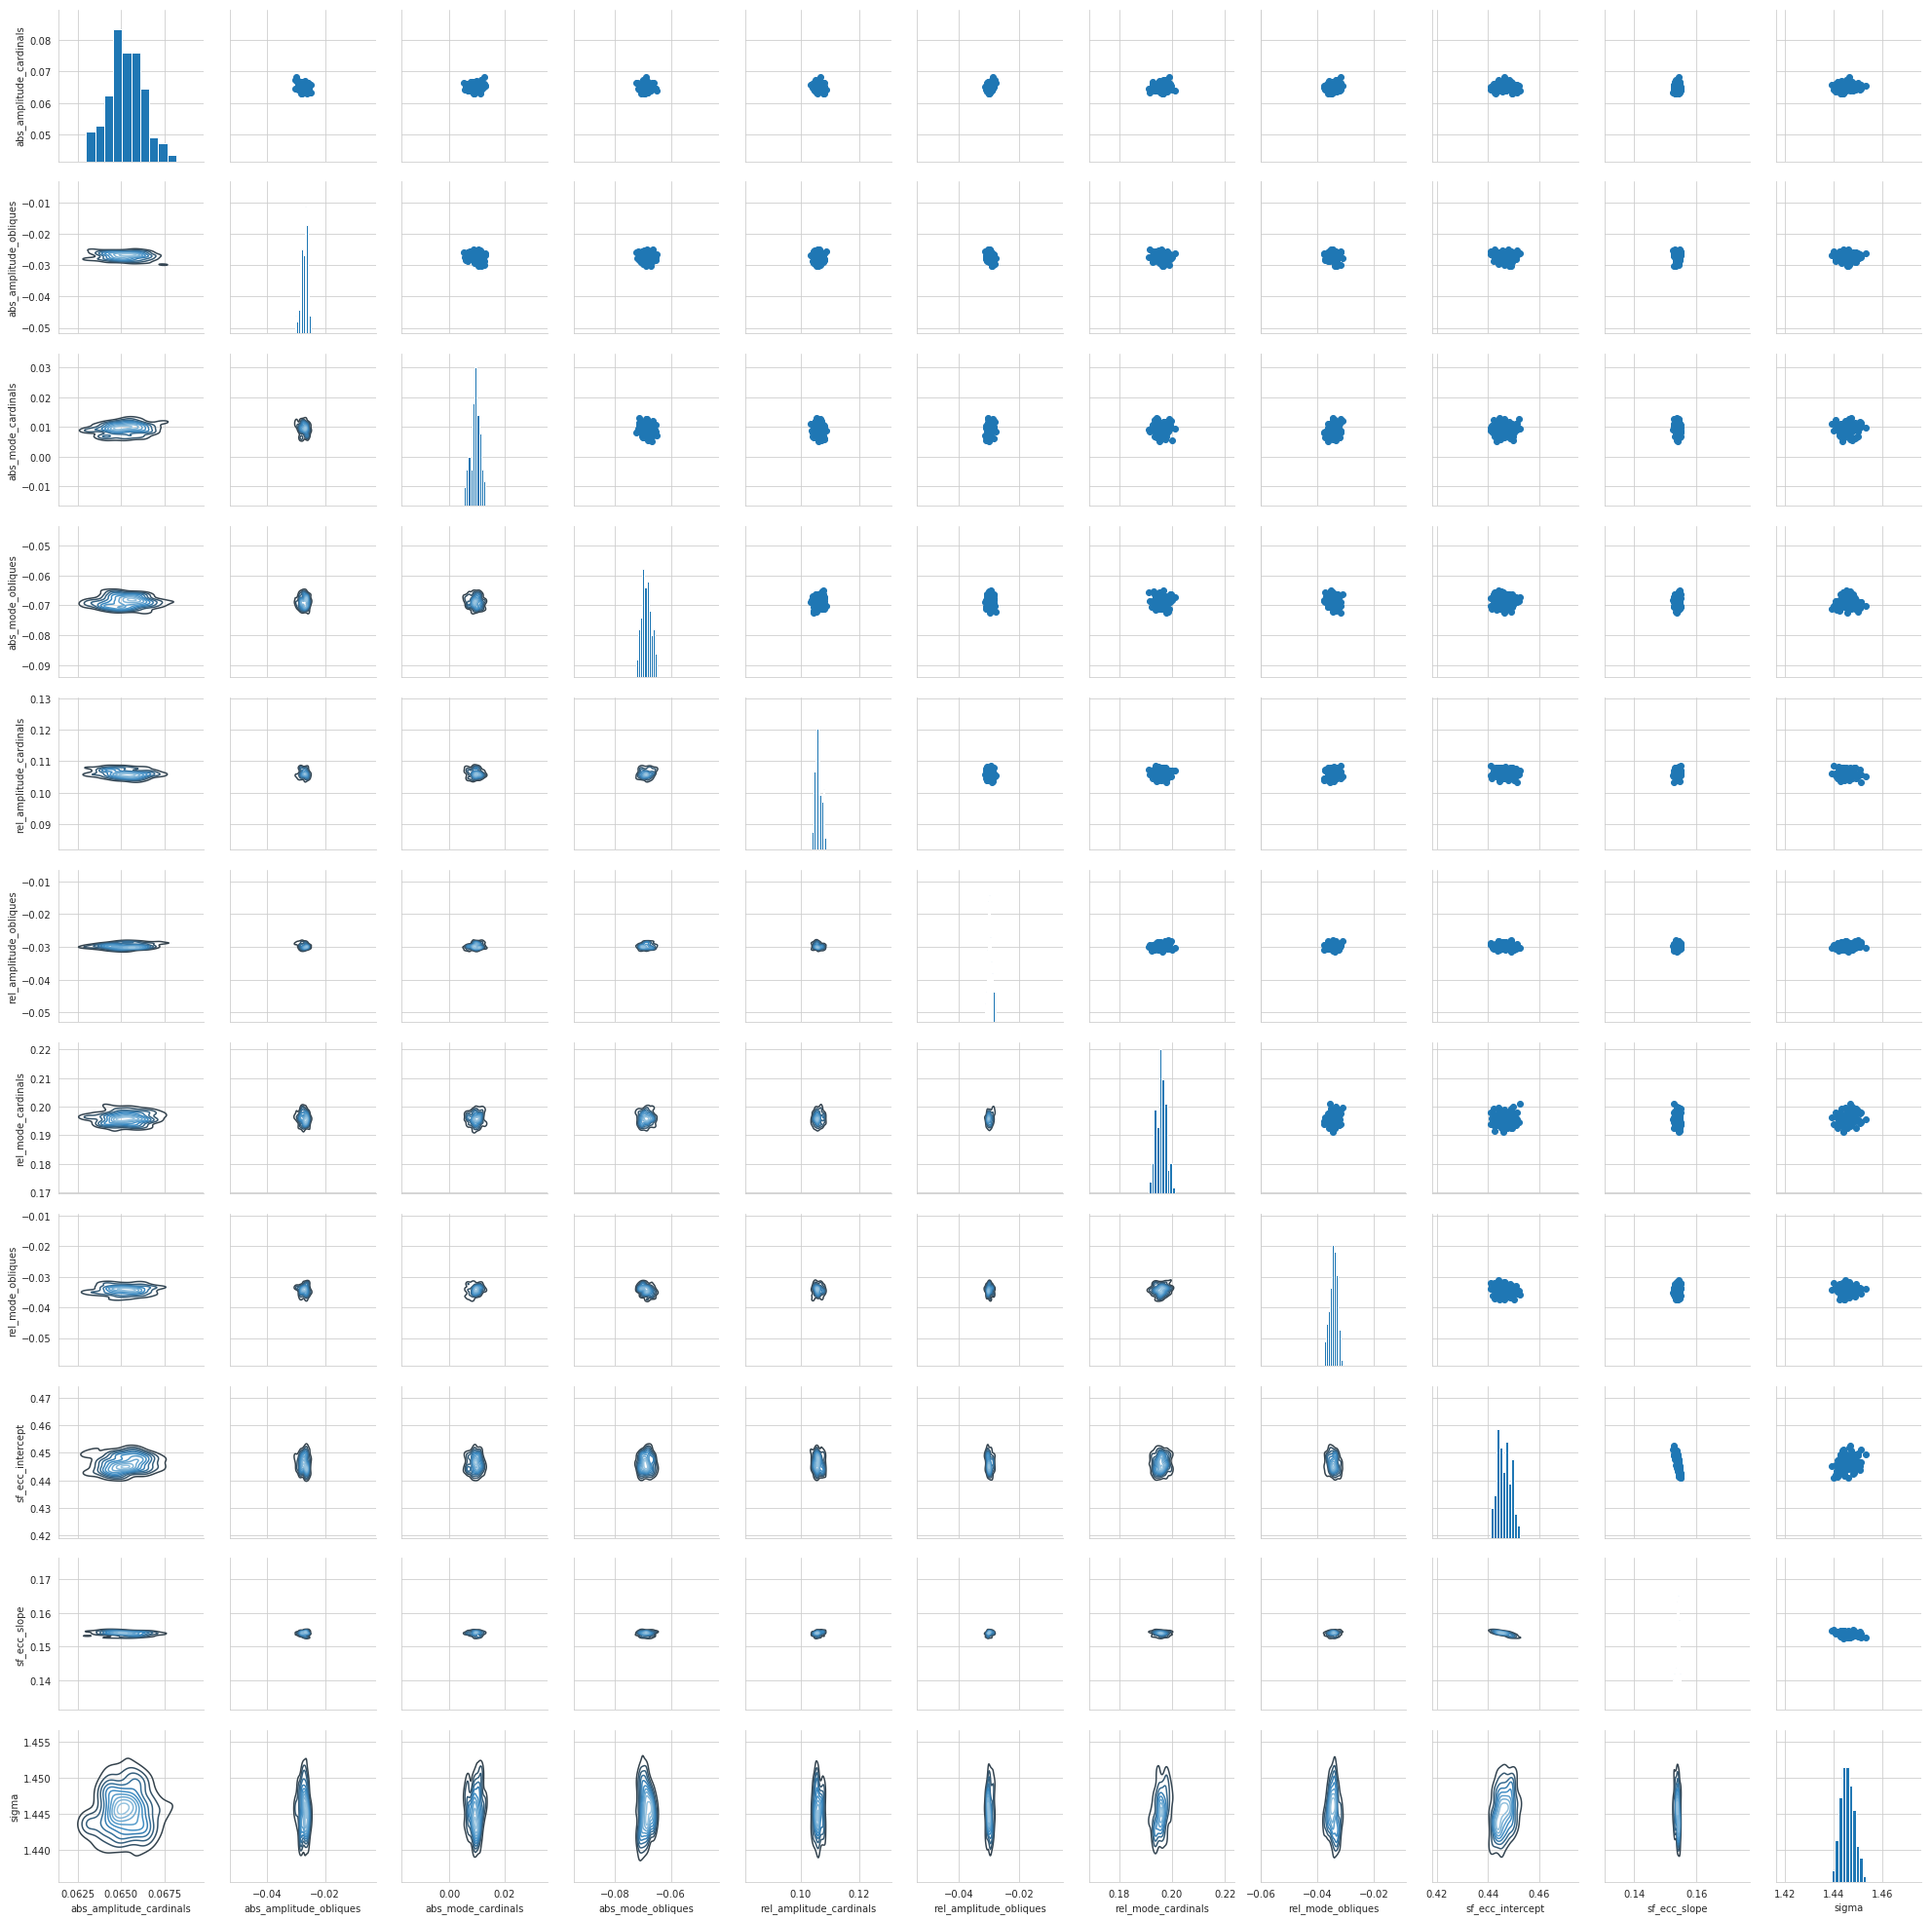

In [213]:
g = sns.PairGrid(samples.pivot('sample_num', 'model_parameter', 'value'))
g = g.map_upper(plt.scatter)
g = g.map_lower(sns.kdeplot, cmap="Blues_d")
g = g.map_diag(plt.hist)

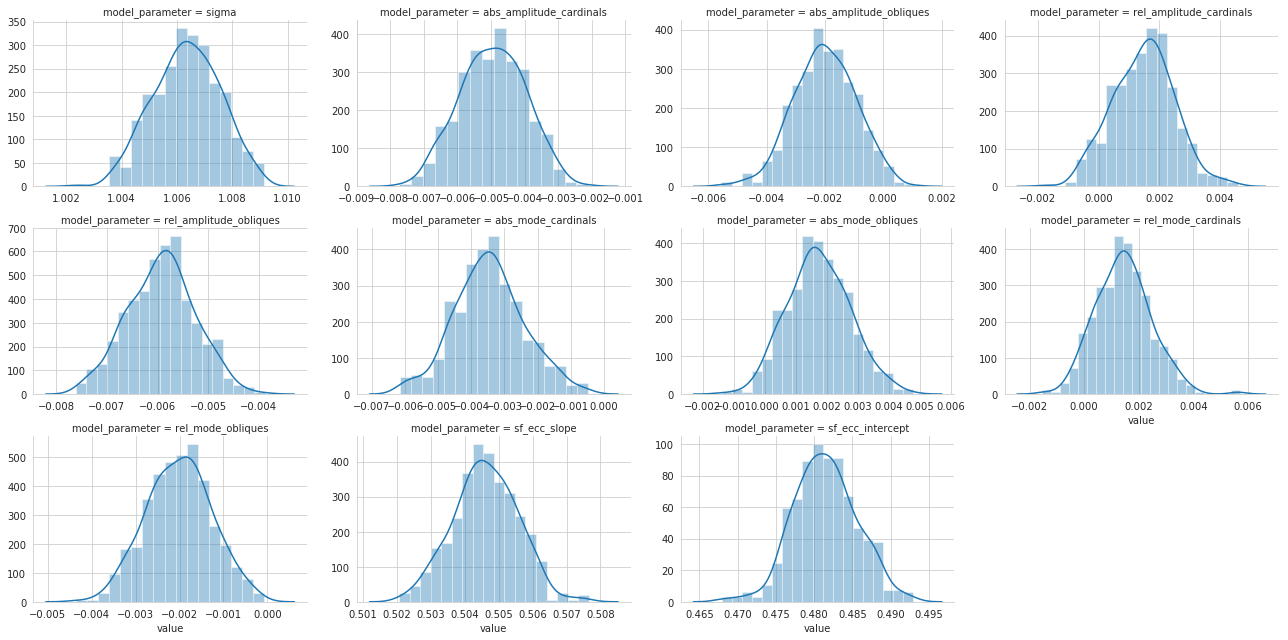

In [60]:
g = sns.FacetGrid(samples, col='model_parameter', col_wrap=4, sharex=False, sharey=False, aspect=1.5)
g.map(sns.distplot, 'value')

In [142]:
# cusum plot:
means = {}
cusum = {}
for p in params:
    means[p] = marginals.support()[p].mean()
    cusum[p] = []
    for t in range(len(marginals.support()[p])):
        cusum[p].append((marginals.support()[p][:t] - means[p]).sum())

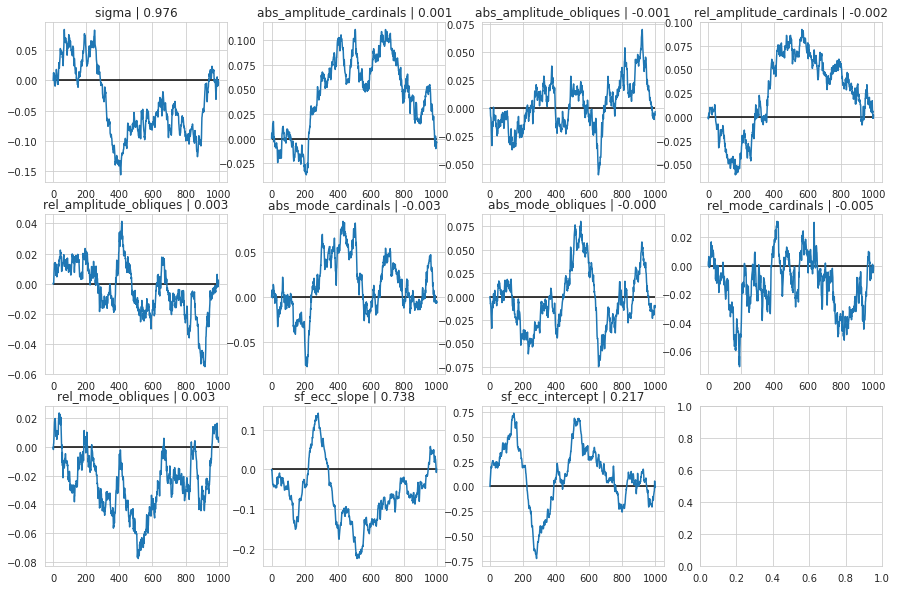

In [143]:
fig, axes = plt.subplots(3, 4, figsize=(15,10))
for ax, p in zip(axes.flatten(), params):
    ax.plot(cusum[p])
    ax.hlines(0, 0, len(cusum[p]))
    ax.set_title("%s | %.03f" % (p.replace('module$$$', ''), marginals.support()[p].mean()))

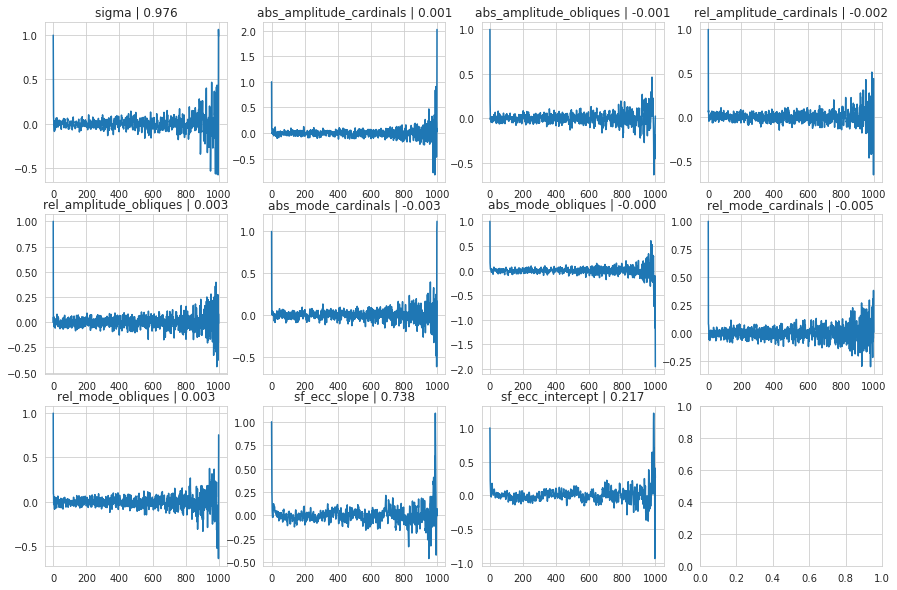

In [151]:
fig, axes = plt.subplots(3, 4, figsize=(15,10))
for ax, p in zip(axes.flatten(), params):
    ax.plot(pyro.ops.stats.autocorrelation(marginals.support()[p]).numpy())
    ax.set_title("%s | %.03f" % (p.replace('module$$$', ''), marginals.support()[p].mean()))